Data from https://www.kaggle.com/debajyotipodder/co2-emission-by-vehicles

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.kernel_approximation import Nystroem

from sklearn_extra.robust import RobustWeightedRegressor
    
pd.set_option('display.max_columns', 300) # Display up to 300 columns from pandas

In [10]:
df = pd.read_csv('data/co2/CO2 Emissions_Canada.csv')

In [11]:
X = df[df.columns[:-1]]
y = df['CO2 Emissions(g/km)']

In [12]:
X = X.drop(columns=['Make', 'Model'])

In [13]:
X.head()

,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg)
0,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33
1,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29
2,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48
3,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25
4,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27


In [14]:
X.shape

(7385, 9)

<AxesSubplot:xlabel='CO2 Emissions(g/km)', ylabel='Count'>

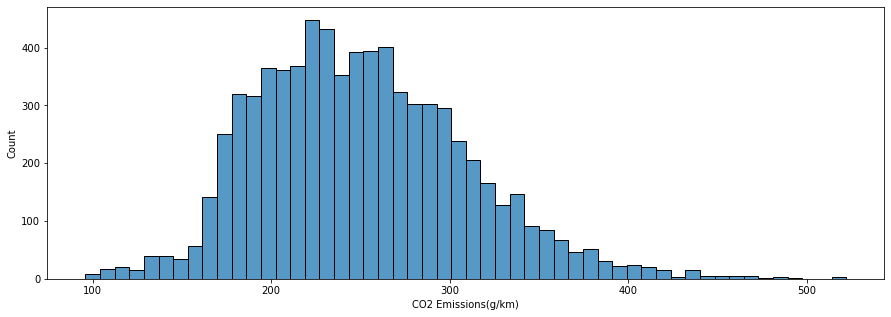

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(data = df, x='CO2 Emissions(g/km)')

In [16]:
X = pd.get_dummies(X, drop_first=False)
X.columns.shape

(54,)

In [17]:
from sklearn_extra.robust import RobustWeightedRegressor
reg = Pipeline(steps=[('scaler', RobustScaler()),
                ('reg',RobustWeightedRegressor(burn_in=0, k=20, weighting='mom'))])
print(np.mean(cross_val_score(reg, X, y, cv=5, scoring="neg_median_absolute_error")))

-2.5002496031008206


In [18]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
print(np.mean(cross_val_score(reg, X, y, cv=5, scoring="neg_median_absolute_error")))

-1.75994689199689


In [19]:
scaler = RobustScaler()
X_transformed = scaler.fit_transform(X)
reg = RobustWeightedRegressor(burn_in=0, k=20, weighting='mom', tol=-10, max_iter = 500) 
# set a negative tolerance to force the algorithm to stop late. 
# It is needed because the weights for mom need a lot of iterations to be computed.
reg.fit(X_transformed,y)

/home/frost/info/scikit-learn-extra/scikit-learn-extra/sklearn_extra/robust/robust_weighted_estimator.py:393: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RobustWeightedRegressor(burn_in=0, k=20, max_iter=500, tol=-10, weighting='mom')

<BarContainer object of 500 artists>

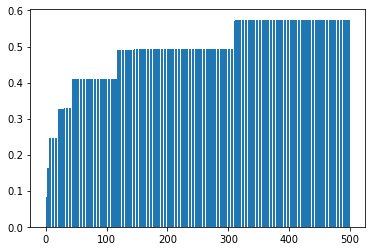

In [20]:
plt.bar(np.arange(len(reg.weights_))[:500], np.sort(reg.weights_)[:500])

In [21]:
outliers = np.argsort(reg.weights_)[:10]

In [22]:
df.iloc[outliers]

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
1530,GMC,SAVANA 2500 PASSENGER FFV,VAN - PASSENGER,6.0,8,A6,E,30.3,20.5,25.9,11,414
225,CHEVROLET,EXPRESS 2500 PASSENGER,VAN - PASSENGER,6.0,8,A6,E,30.0,20.4,25.7,11,411
1534,GMC,SAVANA 3500 PASSENGER FFV,VAN - PASSENGER,6.0,8,A6,E,30.6,20.6,26.1,11,418
452,GMC,SAVANA 3500 PASSENGER,VAN - PASSENGER,6.0,8,A6,E,30.2,20.5,25.8,11,413
1329,CHEVROLET,EXPRESS 3500 PASSENGER FFV,VAN - PASSENGER,6.0,8,A6,E,30.6,20.6,26.1,11,418
228,CHEVROLET,EXPRESS 3500 PASSENGER,VAN - PASSENGER,6.0,8,A6,E,30.2,20.5,25.8,11,413
5120,MERCEDES-BENZ,AMG C 63 S COUPE,SUBCOMPACT,4.0,8,A7,Z,13.8,10.2,12.2,23,285
7339,TOYOTA,Highlander Hybrid AWD,SUV - STANDARD,2.5,4,AV,X,6.7,6.8,6.7,42,158
4816,GMC,CANYON 4WD,PICKUP TRUCK - SMALL,2.8,4,A6,D,12.1,8.3,10.4,27,279
3419,BMW,M240i CABRIOLET,SUBCOMPACT,3.0,6,M6,Z,12.2,8.2,10.4,27,242


It seems there are indeed some outlying caracteristics in these cars. A lot of them have a CO2 emision above 300 which is abnormal. 


On the other hand, for instance there is the "Highlander Hybrid AWD" which present a very low CO2 emission but a large Fuel Consumption. 

We would need to ask a car specialist to know for sure whether all these cars are outliers in regard to their CO2 emissions compared to the features but we can already spot some abnormal cases.